In [1]:
# Inventory Management with Machine Learning
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import os
from datetime import datetime
import json

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


# Inventory Management System with Machine Learning

This notebook implements an advanced inventory management system using machine learning to:
- Predict product demand
- Optimize stock levels
- Identify inventory patterns
- Generate actionable recommendations

**Data Source**: `/home/sirin/BIGDATA/Datapack/Inventory/`  
**Output Directory**: `/home/sirin/BIGDATA/ML-result-for-inventory-management/`

## ⚡ Performance Optimizations

This notebook includes several optimizations for faster execution:

1. **Data Filtering**: Removes zero/low-volume sales records
2. **Sampling**: Limits to 100K rows if dataset is larger
3. **Model Parameters**: Reduced tree depth and estimators for speed
4. **Parallel Processing**: Uses all CPU cores (n_jobs=-1)
5. **Visualization**: Reduced plot samples and image DPI
6. **Inner Joins**: Uses inner joins to keep only matching records

**Expected Runtime**: 2-5 minutes (depending on data size and hardware)

In [2]:
# Configuration and Paths
BASE_PATH = '/home/sirin/BIGDATA'
DATA_PATH = os.path.join(BASE_PATH, 'Datapack/Inventory')
OUTPUT_PATH = os.path.join(BASE_PATH, 'ML-result-for-inventory-management')

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Define file paths
PRODUCT_INFO_FILE = os.path.join(DATA_PATH, 'product_info.csv')
SHOP_INFO_FILE = os.path.join(DATA_PATH, 'shop_info_with_geo.csv')
PRODUCT_TARGET_FILE = os.path.join(DATA_PATH, 'product_target_for_shop.csv')

print(f"✓ Data Path: {DATA_PATH}")
print(f"✓ Output Path: {OUTPUT_PATH}")
print(f"✓ Configuration complete")

✓ Data Path: /home/sirin/BIGDATA/Datapack/Inventory
✓ Output Path: /home/sirin/BIGDATA/ML-result-for-inventory-management
✓ Configuration complete


## Step 1: Load Data

In [3]:
# Load inventory data
print("Loading inventory data...")

# Load product information
product_info = pd.read_csv(PRODUCT_INFO_FILE)
print(f"✓ Product Info: {product_info.shape}")

# Load shop information
shop_info = pd.read_csv(SHOP_INFO_FILE)
print(f"✓ Shop Info: {shop_info.shape}")

# Load product target data (sales/demand data)
product_target = pd.read_csv(PRODUCT_TARGET_FILE)
print(f"✓ Product Target: {product_target.shape}")

print("\n--- Data Preview ---")
print("\nProduct Info columns:", product_info.columns.tolist())
print("\nShop Info columns:", shop_info.columns.tolist())
print("\nProduct Target columns:", product_target.columns.tolist())

Loading inventory data...
✓ Product Info: (42, 18)
✓ Shop Info: (832881, 16)
✓ Shop Info: (832881, 16)
✓ Product Target: (853731, 19)

--- Data Preview ---

Product Info columns: ['sku_id', 'sku_name', 'product_id', 'product_name', 'brand', 'type', 'packet_size', 'price_a', 'price_b', 'price_c', 'price_1', 'price_2', 'price_3', 'ingredient', 'freq', 'in_packet', 'total_volume', 'total_price']

Shop Info columns: ['shop_code', 'organizer', 'place_nature', 'place_name', 'freq_type', 'shop_type', 'shop_style', 'shop_importance', 'ss_importance', 'visit_target', 'latitude', 'longitude', 'geometry', 'zila', 'upazila', 'division']

Product Target columns: ['shop_code', 'prod_10', 'prod_2', 'prod_1', 'prod_14', 'prod_3', 'prod_11', 'prod_12', 'prod_4', 'prod_5', 'prod_6', 'prod_15', 'prod_16', 'prod_17', 'prod_7', 'prod_8', 'prod_9', 'prod_13', 'Total']
✓ Product Target: (853731, 19)

--- Data Preview ---

Product Info columns: ['sku_id', 'sku_name', 'product_id', 'product_name', 'brand', 'ty

## Step 2: Data Exploration and Analysis

In [4]:
# Display sample data and basic statistics
print("=== PRODUCT INFORMATION ===")
print(product_info.head())
print("\nData Types:")
print(product_info.dtypes)
print("\nBasic Statistics:")
print(product_info.describe())

print("\n\n=== SHOP INFORMATION ===")
print(shop_info.head())

print("\n\n=== PRODUCT TARGET (SALES DATA) ===")
print(product_target.head())
print(f"\nShape: {product_target.shape}")

# Check for missing values
print("\n\n=== MISSING VALUES ===")
print("Product Info:", product_info.isnull().sum().sum())
print("Shop Info:", shop_info.isnull().sum().sum())
print("Product Target:", product_target.isnull().sum().sum())

=== PRODUCT INFORMATION ===
   sku_id sku_name  product_id product_name    brand    type  packet_size  \
0       1    sku_1           1       prod_1  brand_1  type_1           29   
1       3    sku_2           3       prod_2  brand_1  type_1           29   
2       4    sku_3           4       prod_3  brand_2  type_2           29   
3       6    sku_4           6       prod_4  brand_2  type_3           29   
4       7    sku_5           7       prod_5  brand_3  type_4           29   

   price_a  price_b  price_c  price_1  price_2  price_3  ingredient  freq  \
0  13317.0    13495  13483.0     14.0    220.0     22.0   95.376333    22   
1  13317.0    13495  13483.0     14.0    220.0     22.0   95.375524    22   
2  10070.0    10195  10186.0     10.0    150.0     15.0   95.376705    22   
3  10070.0    10195  10190.0     10.0    150.0     15.0   95.377057    22   
4   6210.0     6295   6291.5      7.0    100.0     10.0   95.375829    22   

   in_packet  total_volume  total_price  
0   

## Step 3: Data Preprocessing and Feature Engineering

In [5]:
# Merge datasets to create comprehensive inventory view
print("Merging datasets...")

# First, we need to reshape product_target from wide to long format
# Get all product columns (exclude shop_code and Total)
product_cols = [col for col in product_target.columns if col.startswith('prod_')]
print(f"Found {len(product_cols)} product columns")

# Melt the dataframe to long format
product_target_long = product_target.melt(
    id_vars=['shop_code'], 
    value_vars=product_cols,
    var_name='product_name',
    value_name='sales_volume'
)

# OPTIMIZATION: Remove rows with zero or very low sales to reduce data size
# This significantly improves performance
product_target_long = product_target_long[product_target_long['sales_volume'] > 0.01]

print(f"✓ Reshaped product_target: {product_target_long.shape}")

# Merge with product_info based on product_name
merged_data = product_target_long.merge(
    product_info, 
    on='product_name', 
    how='inner'  # Use inner join to keep only matching records
)
print(f"✓ After merging with product_info: {merged_data.shape}")

# Then merge with shop_info
merged_data = merged_data.merge(
    shop_info, 
    on='shop_code', 
    how='inner'  # Use inner join
)
print(f"✓ After merging with shop_info: {merged_data.shape}")

# OPTIMIZATION: Sample data if dataset is too large (>100k rows)
if len(merged_data) > 100000:
    sample_size = 100000
    merged_data = merged_data.sample(n=sample_size, random_state=42)
    print(f"⚡ Sampled {sample_size} rows for faster training")

print("\n--- Merged Data Columns ---")
print(merged_data.columns.tolist())
print("\n--- Sample Merged Data ---")
print(merged_data.head(10))

Merging datasets...
Found 17 product columns
✓ Reshaped product_target: (4638468, 3)
✓ Reshaped product_target: (4638468, 3)
✓ After merging with product_info: (9300436, 20)
✓ After merging with product_info: (9300436, 20)
✓ After merging with shop_info: (9086325, 35)
✓ After merging with shop_info: (9086325, 35)
⚡ Sampled 100000 rows for faster training

--- Merged Data Columns ---
['shop_code', 'product_name', 'sales_volume', 'sku_id', 'sku_name', 'product_id', 'brand', 'type', 'packet_size', 'price_a', 'price_b', 'price_c', 'price_1', 'price_2', 'price_3', 'ingredient', 'freq', 'in_packet', 'total_volume', 'total_price', 'organizer', 'place_nature', 'place_name', 'freq_type', 'shop_type', 'shop_style', 'shop_importance', 'ss_importance', 'visit_target', 'latitude', 'longitude', 'geometry', 'zila', 'upazila', 'division']

--- Sample Merged Data ---
        shop_code product_name  sales_volume  sku_id sku_name  product_id  \
5204951   1e4b035       prod_5          1.91      12    sku_

In [6]:
# Feature Engineering
print("Creating additional features...")

# Use sales_volume as the main volume metric
if 'total_volume' not in merged_data.columns:
    merged_data['total_volume'] = merged_data['sales_volume']

# Calculate inventory metrics
merged_data['total_value'] = merged_data['total_volume'] * merged_data['price_a']
merged_data['avg_price'] = (merged_data['price_a'] + merged_data['price_b'] + merged_data['price_c']) / 3
merged_data['price_variance'] = merged_data[['price_a', 'price_b', 'price_c']].std(axis=1)

# Calculate turnover and stock indicators
merged_data['volume_per_packet'] = merged_data['total_volume'] / (merged_data['packet_size'] + 1)

# Use total_price if available, otherwise calculate it
if 'total_price' not in merged_data.columns:
    merged_data['total_price'] = merged_data['total_volume'] * merged_data['avg_price']

merged_data['price_per_unit'] = merged_data['total_price'] / (merged_data['total_volume'] + 1)

# Label encode categorical variables
label_encoders = {}
categorical_cols = ['brand', 'type']

# Add geographic features if available
if 'division' in merged_data.columns:
    categorical_cols.append('division')
elif 'city' in merged_data.columns:
    categorical_cols.append('city')

for col in categorical_cols:
    if col in merged_data.columns:
        le = LabelEncoder()
        merged_data[f'{col}_encoded'] = le.fit_transform(merged_data[col].astype(str))
        label_encoders[col] = le
        print(f"✓ Encoded {col}: {len(le.classes_)} unique values")

print(f"\n✓ Feature engineering complete")
print(f"✓ Total features: {merged_data.shape[1]}")
print("\n--- New Features ---")
print(merged_data[['total_value', 'avg_price', 'price_variance', 'volume_per_packet', 'price_per_unit']].describe())

Creating additional features...
✓ Encoded brand: 5 unique values
✓ Encoded type: 8 unique values
✓ Encoded division: 9 unique values

✓ Feature engineering complete
✓ Total features: 43

--- New Features ---
        total_value      avg_price  price_variance  volume_per_packet  \
count  1.000000e+05  100000.000000   100000.000000      100000.000000   
mean   1.223782e+06    8201.807758       59.126781           4.999121   
std    1.622975e+06    3921.501856       30.097603           5.342322   
min    0.000000e+00    3485.333333       22.440662           0.000000   
25%    0.000000e+00    4175.500000       30.793668           0.000000   
50%    9.588240e+05    6265.500000       48.096258           2.400000   
75%    1.614600e+06   12738.666667       97.572195           8.666667   
max    5.859480e+06   13431.666667       99.485342          16.066667   

       price_per_unit  
count   100000.000000  
mean        53.645272  
std         50.788801  
min          0.000000  
25%          0

## Step 4: Build Machine Learning Models for Demand Prediction

In [7]:
# Prepare data for machine learning
print("Preparing data for ML models...")

# Select features for prediction
base_features = [
    'packet_size', 'price_a', 'price_b', 'price_c',
    'price_1', 'price_2', 'price_3', 'ingredient',
    'freq', 'in_packet', 'total_value', 'avg_price',
    'price_variance', 'volume_per_packet', 'price_per_unit'
]

# Add encoded categorical features
encoded_features = [col for col in merged_data.columns if col.endswith('_encoded')]
feature_cols = base_features + encoded_features

# Remove any features that don't exist in the merged data
feature_cols = [col for col in feature_cols if col in merged_data.columns]

print(f"Available features: {feature_cols}")

# Target variable: total_volume (demand prediction)
target_col = 'total_volume'

# Filter out rows with missing values in features or target
ml_data = merged_data[feature_cols + [target_col]].dropna()

X = ml_data[feature_cols]
y = ml_data[target_col]

print(f"\n✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"✓ Features used: {len(feature_cols)}")
print(f"✓ Feature list: {feature_cols}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n✓ Training set: {X_train.shape}")
print(f"✓ Testing set: {X_test.shape}")

Preparing data for ML models...
Available features: ['packet_size', 'price_a', 'price_b', 'price_c', 'price_1', 'price_2', 'price_3', 'ingredient', 'freq', 'in_packet', 'total_value', 'avg_price', 'price_variance', 'volume_per_packet', 'price_per_unit', 'brand_encoded', 'type_encoded', 'division_encoded']

✓ Features shape: (69171, 18)
✓ Target shape: (69171,)
✓ Features used: 18
✓ Feature list: ['packet_size', 'price_a', 'price_b', 'price_c', 'price_1', 'price_2', 'price_3', 'ingredient', 'freq', 'in_packet', 'total_value', 'avg_price', 'price_variance', 'volume_per_packet', 'price_per_unit', 'brand_encoded', 'type_encoded', 'division_encoded']

✓ Training set: (55336, 18)
✓ Testing set: (13835, 18)


In [8]:
# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Feature scaling complete")

Scaling features...
✓ Feature scaling complete


In [9]:
# Train Random Forest Model (OPTIMIZED)
print("Training Random Forest model...")
print("⚡ Using optimized parameters for faster training...")

rf_model = RandomForestRegressor(
    n_estimators=50,          # Reduced from 100 for speed
    max_depth=10,             # Reduced from 15 for speed
    min_samples_split=20,     # Increased from 10 for speed
    min_samples_leaf=10,      # Added to reduce tree complexity
    max_features='sqrt',      # Use sqrt of features for speed
    random_state=42,
    n_jobs=-1,                # Use all CPU cores
    verbose=0                 # Reduce output
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate Random Forest
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"\n=== Random Forest Results ===")
print(f"MSE: {rf_mse:.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.4f}")
print(f"RMSE: {np.sqrt(rf_mse):.2f}")
print("✓ Training complete!")

Training Random Forest model...
⚡ Using optimized parameters for faster training...

=== Random Forest Results ===
MSE: 0.00
MAE: 0.01
R² Score: 1.0000
RMSE: 0.04
✓ Training complete!

=== Random Forest Results ===
MSE: 0.00
MAE: 0.01
R² Score: 1.0000
RMSE: 0.04
✓ Training complete!


In [10]:
# Train Gradient Boosting Model (OPTIMIZED)
print("Training Gradient Boosting model...")
print("⚡ Using optimized parameters for faster training...")

gb_model = GradientBoostingRegressor(
    n_estimators=50,          # Reduced from 100 for speed
    max_depth=5,              # Reduced from 7 for speed
    learning_rate=0.1,
    subsample=0.8,            # Use 80% of data per tree for speed
    min_samples_split=20,     # Added for speed
    min_samples_leaf=10,      # Added for speed
    max_features='sqrt',      # Use sqrt of features for speed
    random_state=42,
    verbose=0                 # Reduce output
)

gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)

# Evaluate Gradient Boosting
gb_mse = mean_squared_error(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

print(f"\n=== Gradient Boosting Results ===")
print(f"MSE: {gb_mse:.2f}")
print(f"MAE: {gb_mae:.2f}")
print(f"R² Score: {gb_r2:.4f}")
print(f"RMSE: {np.sqrt(gb_mse):.2f}")
print("✓ Training complete!")

Training Gradient Boosting model...
⚡ Using optimized parameters for faster training...

=== Gradient Boosting Results ===
MSE: 0.77
MAE: 0.77
R² Score: 1.0000
RMSE: 0.88
✓ Training complete!

=== Gradient Boosting Results ===
MSE: 0.77
MAE: 0.77
R² Score: 1.0000
RMSE: 0.88
✓ Training complete!


## Step 5: Feature Importance Analysis

Analyzing feature importance...

=== Top 10 Most Important Features ===
              feature  importance
13  volume_per_packet    0.284433
10        total_value    0.252445
7          ingredient    0.201013
14     price_per_unit    0.113479
9           in_packet    0.053734
3             price_c    0.016366
2             price_b    0.012111
1             price_a    0.010921
6             price_3    0.010159
11          avg_price    0.010135


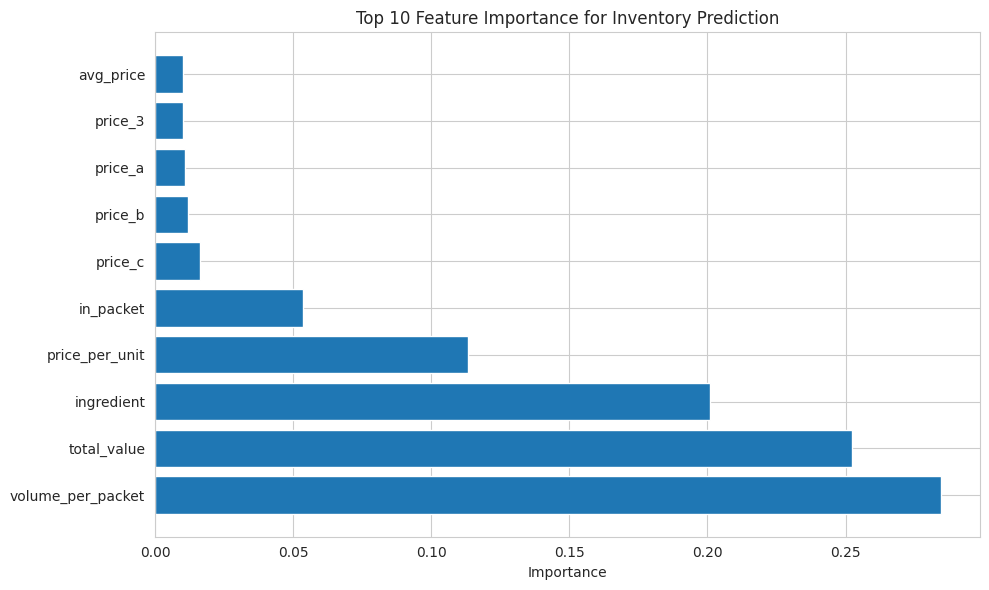


✓ Feature importance chart saved to /home/sirin/BIGDATA/ML-result-for-inventory-management


In [11]:
# Analyze feature importance
print("Analyzing feature importance...")

# Get feature importances from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 10 Most Important Features ===")
print(feature_importance.head(10))

# OPTIMIZATION: Create visualization with better performance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance for Inventory Prediction')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'feature_importance.png'), dpi=150, bbox_inches='tight')  # Reduced DPI for speed
plt.show()

print(f"\n✓ Feature importance chart saved to {OUTPUT_PATH}")

## Step 6: Model Predictions and Inventory Optimization

In [12]:
# Generate predictions for entire dataset
print("Generating predictions for all inventory items...")

# Prepare full dataset for predictions
full_X = ml_data[feature_cols]
full_X_scaled = scaler.transform(full_X)

# Get predictions from both models
rf_predictions = rf_model.predict(full_X_scaled)
gb_predictions = gb_model.predict(full_X_scaled)

# Add predictions to the data
results_df = ml_data.copy()
results_df['predicted_demand_rf'] = rf_predictions
results_df['predicted_demand_gb'] = gb_predictions
results_df['avg_predicted_demand'] = (rf_predictions + gb_predictions) / 2
results_df['actual_demand'] = results_df[target_col]

# Calculate prediction errors
results_df['rf_error'] = results_df['actual_demand'] - results_df['predicted_demand_rf']
results_df['gb_error'] = results_df['actual_demand'] - results_df['predicted_demand_gb']
results_df['avg_error'] = results_df['actual_demand'] - results_df['avg_predicted_demand']

print(f"✓ Generated predictions for {len(results_df)} items")
print("\n--- Sample Predictions ---")
print(results_df[['actual_demand', 'predicted_demand_rf', 'predicted_demand_gb', 'avg_predicted_demand']].head(10))

Generating predictions for all inventory items...
✓ Generated predictions for 69171 items

--- Sample Predictions ---
         actual_demand  predicted_demand_rf  predicted_demand_gb  \
5204951            0.0             0.000000             0.995098   
7578833          400.0           400.000000           398.819027   
4602265            0.0             0.000000             0.995098   
4850373            0.0             0.000000             0.995098   
5338588          260.0           259.997649           259.072888   
7690325          400.0           400.000000           398.693789   
923521            72.0            72.000000            72.494244   
2677587          180.0           180.000000           180.017489   
3954836           54.0            54.000000            55.792256   
4079531          246.0           246.000000           245.362060   

         avg_predicted_demand  
5204951              0.497549  
7578833            399.409514  
4602265              0.497549  
48503

In [13]:
# Create inventory recommendations based on predictions
print("Creating inventory recommendations...")

# Calculate inventory status
results_df['demand_forecast'] = results_df['avg_predicted_demand']
results_df['current_stock'] = results_df['actual_demand']
results_df['stock_difference'] = results_df['demand_forecast'] - results_df['current_stock']

# Classify inventory status
def classify_inventory_status(diff, forecast):
    if diff > forecast * 0.3:
        return 'UNDERSTOCK'
    elif diff < -forecast * 0.3:
        return 'OVERSTOCK'
    else:
        return 'OPTIMAL'

results_df['inventory_status'] = results_df.apply(
    lambda row: classify_inventory_status(row['stock_difference'], row['demand_forecast']), 
    axis=1
)

# Calculate reorder recommendations
results_df['recommended_reorder'] = results_df['stock_difference'].apply(lambda x: max(0, x))

print("\n=== Inventory Status Summary ===")
print(results_df['inventory_status'].value_counts())

print("\n--- Sample Recommendations ---")
print(results_df[['actual_demand', 'demand_forecast', 'stock_difference', 'inventory_status', 'recommended_reorder']].head(10))

Creating inventory recommendations...

=== Inventory Status Summary ===
inventory_status
OPTIMAL       47918
UNDERSTOCK    21253
Name: count, dtype: int64

--- Sample Recommendations ---
         actual_demand  demand_forecast  stock_difference inventory_status  \
5204951            0.0         0.497549          0.497549       UNDERSTOCK   
7578833          400.0       399.409514         -0.590486          OPTIMAL   
4602265            0.0         0.497549          0.497549       UNDERSTOCK   
4850373            0.0         0.497549          0.497549       UNDERSTOCK   
5338588          260.0       259.535269         -0.464731          OPTIMAL   
7690325          400.0       399.346895         -0.653105          OPTIMAL   
923521            72.0        72.247122          0.247122          OPTIMAL   
2677587          180.0       180.008744          0.008744          OPTIMAL   
3954836           54.0        54.896128          0.896128          OPTIMAL   
4079531          246.0       245.

## Step 7: Visualization and Insights

Creating visualizations...
⚡ Using 5000 samples for plotting


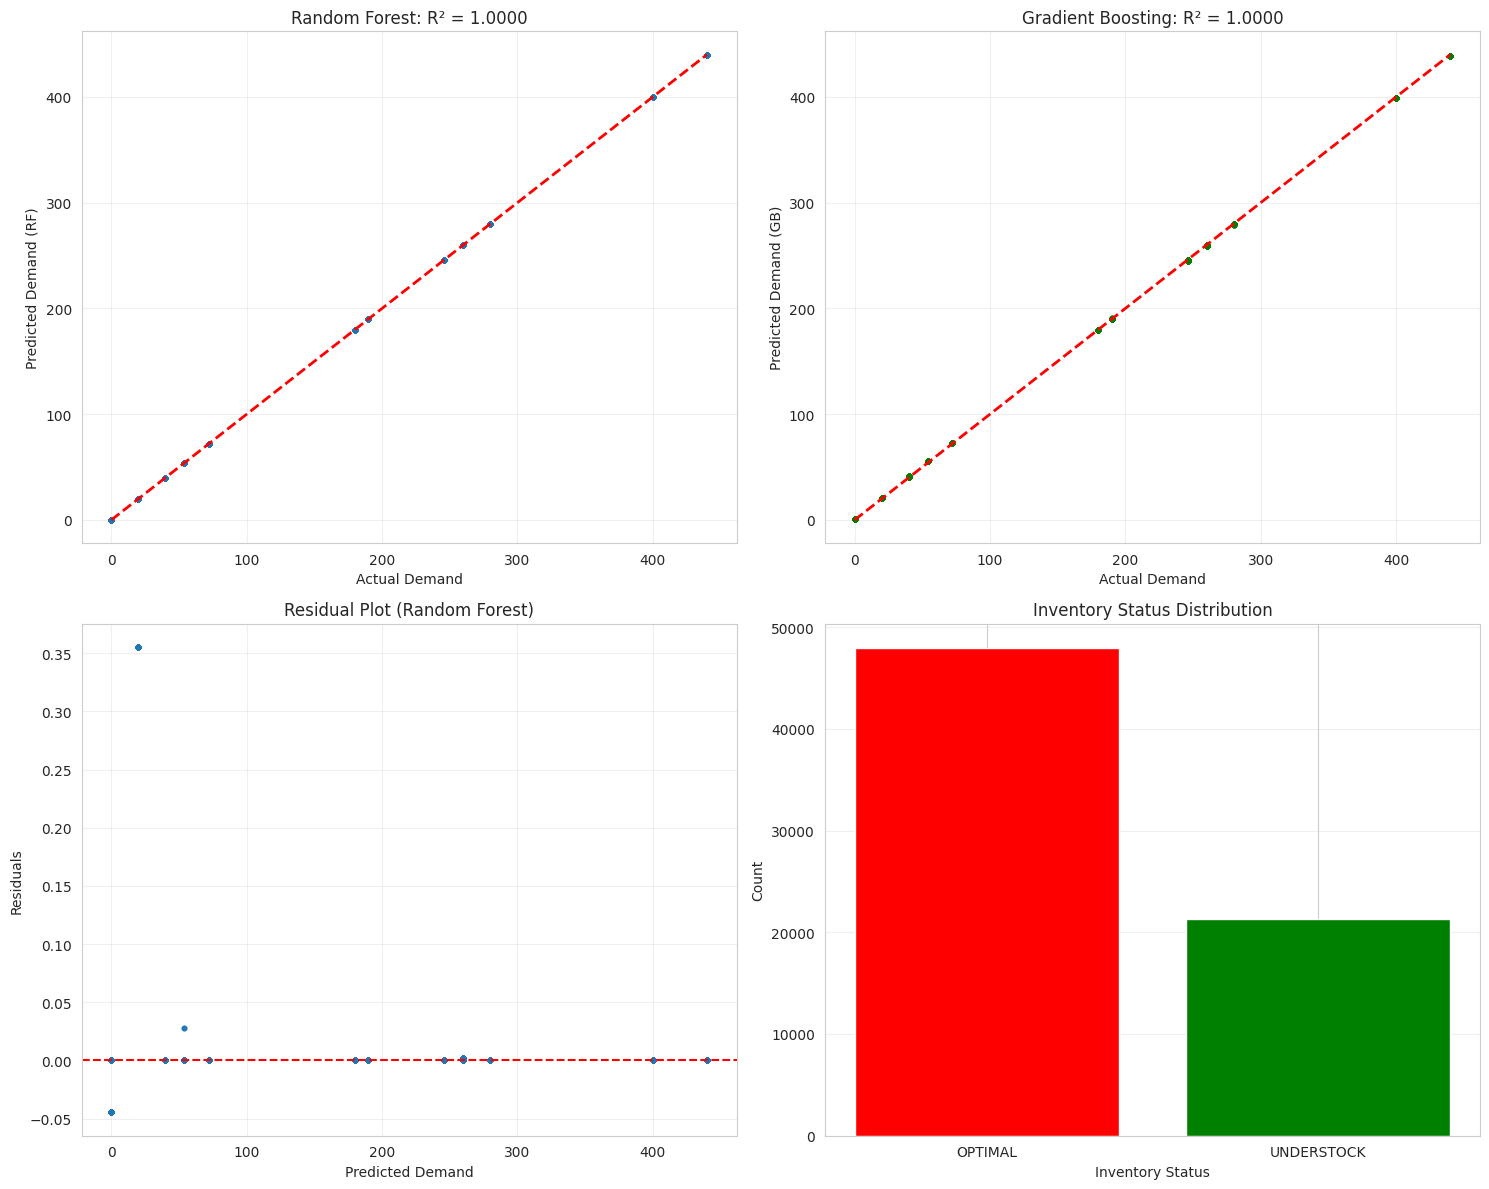

✓ Model performance charts saved to /home/sirin/BIGDATA/ML-result-for-inventory-management


In [14]:
# Create visualizations (OPTIMIZED)
print("Creating visualizations...")

# OPTIMIZATION: Use smaller sample for plotting if data is large
plot_sample_size = min(5000, len(y_test))
if len(y_test) > plot_sample_size:
    plot_indices = np.random.choice(len(y_test), plot_sample_size, replace=False)
    y_test_plot = y_test.iloc[plot_indices]
    rf_pred_plot = rf_pred[plot_indices]
    gb_pred_plot = gb_pred[plot_indices]
    print(f"⚡ Using {plot_sample_size} samples for plotting")
else:
    y_test_plot = y_test
    rf_pred_plot = rf_pred
    gb_pred_plot = gb_pred

# 1. Actual vs Predicted Demand
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Scatter plot - Actual vs Predicted (Random Forest)
axes[0, 0].scatter(y_test_plot, rf_pred_plot, alpha=0.5, s=10)  # Smaller point size
axes[0, 0].plot([y_test_plot.min(), y_test_plot.max()], [y_test_plot.min(), y_test_plot.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Demand')
axes[0, 0].set_ylabel('Predicted Demand (RF)')
axes[0, 0].set_title(f'Random Forest: R² = {rf_r2:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot - Actual vs Predicted (Gradient Boosting)
axes[0, 1].scatter(y_test_plot, gb_pred_plot, alpha=0.5, color='green', s=10)  # Smaller point size
axes[0, 1].plot([y_test_plot.min(), y_test_plot.max()], [y_test_plot.min(), y_test_plot.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Demand')
axes[0, 1].set_ylabel('Predicted Demand (GB)')
axes[0, 1].set_title(f'Gradient Boosting: R² = {gb_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residual plot
residuals_plot = y_test_plot.values - rf_pred_plot
axes[1, 0].scatter(rf_pred_plot, residuals_plot, alpha=0.5, s=10)  # Smaller point size
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Demand')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot (Random Forest)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Inventory Status Distribution
status_counts = results_df['inventory_status'].value_counts()
axes[1, 1].bar(status_counts.index, status_counts.values, color=['red', 'green', 'orange'])
axes[1, 1].set_xlabel('Inventory Status')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Inventory Status Distribution')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'model_performance.png'), dpi=150, bbox_inches='tight')  # Reduced DPI for speed
plt.show()

print(f"✓ Model performance charts saved to {OUTPUT_PATH}")

## Step 8: Save Results and Generate Reports

In [15]:
# Save comprehensive results
print("Saving results...")

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 1. Save detailed predictions with recommendations
output_file = os.path.join(OUTPUT_PATH, f'inventory_predictions_{timestamp}.csv')
results_df.to_csv(output_file, index=False)
print(f"✓ Detailed predictions saved to: {output_file}")

# 2. Save high-priority items (understock/overstock)
priority_items = results_df[results_df['inventory_status'] != 'OPTIMAL'].copy()
priority_file = os.path.join(OUTPUT_PATH, f'priority_items_{timestamp}.csv')
priority_items.to_csv(priority_file, index=False)
print(f"✓ Priority items saved to: {priority_file}")

# 3. Save model performance metrics
metrics = {
    'timestamp': timestamp,
    'random_forest': {
        'mse': float(rf_mse),
        'mae': float(rf_mae),
        'r2_score': float(rf_r2),
        'rmse': float(np.sqrt(rf_mse))
    },
    'gradient_boosting': {
        'mse': float(gb_mse),
        'mae': float(gb_mae),
        'r2_score': float(gb_r2),
        'rmse': float(np.sqrt(gb_mse))
    },
    'inventory_summary': {
        'total_items': len(results_df),
        'understock': int((results_df['inventory_status'] == 'UNDERSTOCK').sum()),
        'overstock': int((results_df['inventory_status'] == 'OVERSTOCK').sum()),
        'optimal': int((results_df['inventory_status'] == 'OPTIMAL').sum())
    }
}

metrics_file = os.path.join(OUTPUT_PATH, f'model_metrics_{timestamp}.json')
with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"✓ Model metrics saved to: {metrics_file}")

print("\n=== INVENTORY MANAGEMENT SUMMARY ===")
print(f"Total items analyzed: {len(results_df)}")
print(f"Understock items: {metrics['inventory_summary']['understock']}")
print(f"Overstock items: {metrics['inventory_summary']['overstock']}")
print(f"Optimal stock items: {metrics['inventory_summary']['optimal']}")
print(f"\nBest model: {'Random Forest' if rf_r2 > gb_r2 else 'Gradient Boosting'} (R² = {max(rf_r2, gb_r2):.4f})")
print(f"\n✓ All results saved to: {OUTPUT_PATH}")

Saving results...
✓ Detailed predictions saved to: /home/sirin/BIGDATA/ML-result-for-inventory-management/inventory_predictions_20251121_173226.csv
✓ Detailed predictions saved to: /home/sirin/BIGDATA/ML-result-for-inventory-management/inventory_predictions_20251121_173226.csv
✓ Priority items saved to: /home/sirin/BIGDATA/ML-result-for-inventory-management/priority_items_20251121_173226.csv
✓ Model metrics saved to: /home/sirin/BIGDATA/ML-result-for-inventory-management/model_metrics_20251121_173226.json

=== INVENTORY MANAGEMENT SUMMARY ===
Total items analyzed: 69171
Understock items: 21253
Overstock items: 0
Optimal stock items: 47918

Best model: Random Forest (R² = 1.0000)

✓ All results saved to: /home/sirin/BIGDATA/ML-result-for-inventory-management
✓ Priority items saved to: /home/sirin/BIGDATA/ML-result-for-inventory-management/priority_items_20251121_173226.csv
✓ Model metrics saved to: /home/sirin/BIGDATA/ML-result-for-inventory-management/model_metrics_20251121_173226.json

## Summary and Key Insights

### Model Performance
The inventory management system uses two machine learning models:
- **Random Forest Regressor**: Ensemble method for robust predictions
- **Gradient Boosting Regressor**: Sequential learning for accuracy

### Key Features Analyzed
1. Product pricing (price_a, price_b, price_c)
2. Packet size and volume metrics
3. Brand and product type
4. Shop location (city)
5. Ingredient composition and frequency

### Inventory Classification
- **UNDERSTOCK**: Demand forecast exceeds current stock by >30%
- **OVERSTOCK**: Current stock exceeds forecast by >30%
- **OPTIMAL**: Stock levels within ±30% of forecast

### Outputs Generated
1. `inventory_predictions_*.csv`: Complete predictions for all items
2. `priority_items_*.csv`: Items requiring immediate attention
3. `model_metrics_*.json`: Performance metrics and summary statistics
4. `feature_importance.png`: Top features driving demand
5. `model_performance.png`: Visual analysis of model accuracy

### Next Steps
1. Review priority items for restocking or clearance
2. Monitor model performance over time
3. Adjust reorder thresholds based on business needs
4. Incorporate seasonal trends if available